In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
import mat73
import random
from datetime import datetime

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

import albumentations as A

In [2]:
data_path = "/media/mountHDD2/nyu/nyu_depth_v2_labeled.mat"
raw_data = mat73.loadmat(data_path)

ERROR:root:ERROR: MATLAB type not supported: containers.Map, (uint32)


In [3]:
del raw_data['accelData']
del raw_data['depths']
del raw_data['instances']
del raw_data['rawDepthFilenames']
del raw_data['rawDepths']
del raw_data['rawRgbFilenames']
del raw_data['sceneTypes']
del raw_data['scenes']

In [4]:
transform_lst = [
    A.HorizontalFlip(p=0.2),    
    A.OneOf([
        A.GaussNoise(var_limit=(2.0, 5.0)),
        A.RandomRain(),
        A.RandomSunFlare(src_radius=150) #Make Flare
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.2),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=3, p=0.3,
                      border_mode = cv2.BORDER_CONSTANT),
    A.OneOf([
        A.OpticalDistortion(p=0.3),
        A.GridDistortion(p=0.1),
        A.PiecewiseAffine(p=0.3),
    ], p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
        A.RandomBrightnessContrast(),   
        A.Downscale(interpolation = {
            "downscale": cv2.INTER_NEAREST,
            "upscale": cv2.INTER_NEAREST
        }),
    ], p=0.3),
    A.OneOf([
        A.HueSaturationValue(p=0.3),
        A.ColorJitter(p=0.3),
    ], p= 0.3),
    A.RGBShift(p=0.2),
    A.RandomShadow(p=0.2),
    A.ElasticTransform(
        p=0.2, border_mode = cv2.BORDER_CONSTANT,
        alpha_affine = 20
    )
]

In [5]:
class NYU(Dataset):
    def __init__(self, raw_data, aug = False, resize = None):
        super().__init__()

        self.cls_cnt = len(raw_data["names"]) + 1
        self.aug = aug
        self.images = np.moveaxis(raw_data["images"], -1, 0)
        self.masks = np.moveaxis(raw_data["labels"], -1, 0)
        self.resize = A.Compose(
            [
                A.Resize(resize[0], resize[1])
            ]
        ) if resize else None

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        if self.resize is not None:
            resized = self.resize(image = img, mask = mask)
            img = resized['image']
            mask = resized['mask']
        
        if self.aug:
            random.shuffle(transform_lst)
    
            transform = A.Compose(transform_lst)
    
            transformed = transform(image = img, mask = mask)
            
            img = transformed['image']
            mask = transformed['mask']

        torch_image = torch.from_numpy(img).permute(-1, 0, 1)
        torch_mask = F.one_hot(
            torch.from_numpy(mask.astype(np.int64)).unsqueeze(0), self.cls_cnt
        ).permute(0, 3, 1, 2)[0].float()

        return (torch_image, torch_mask)

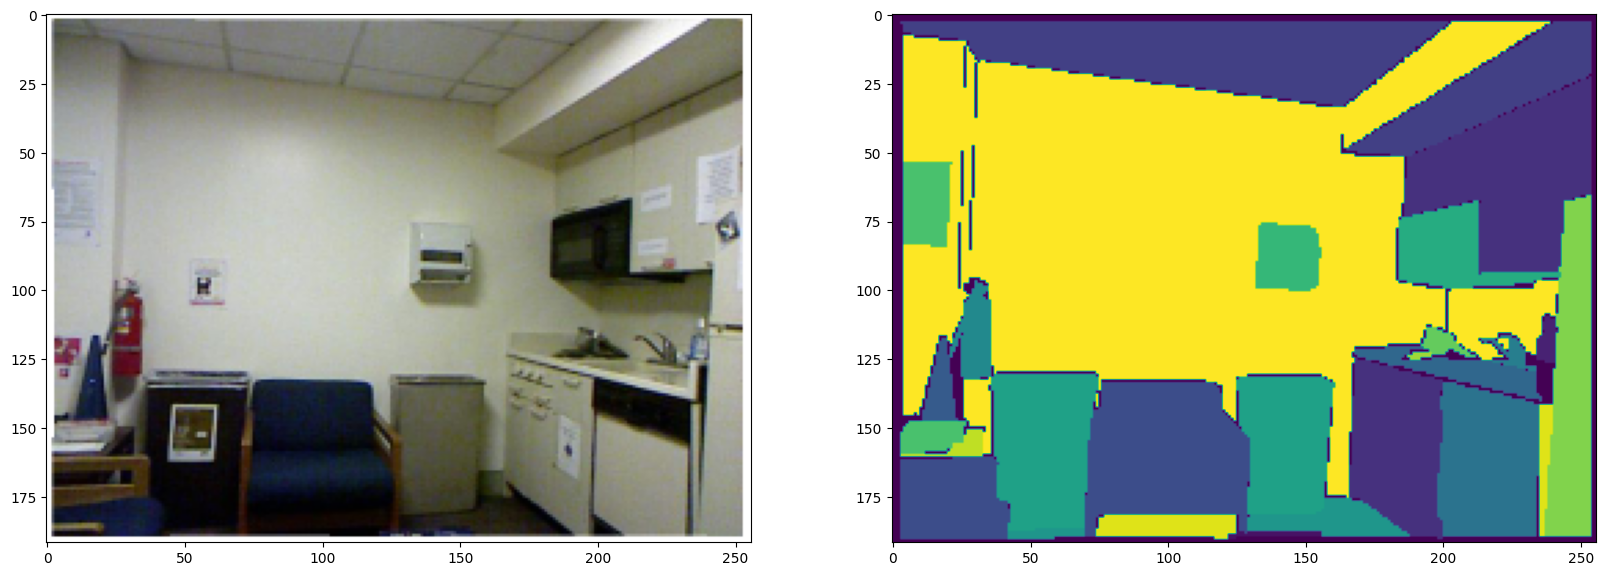

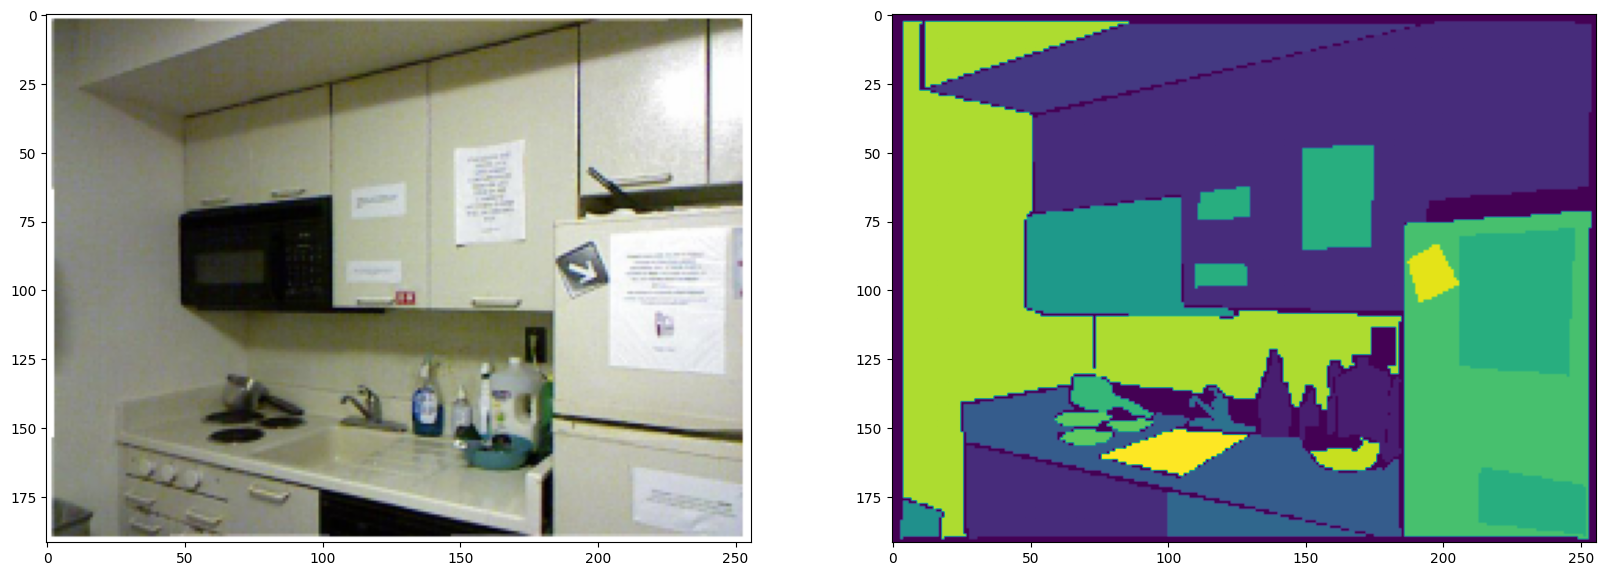

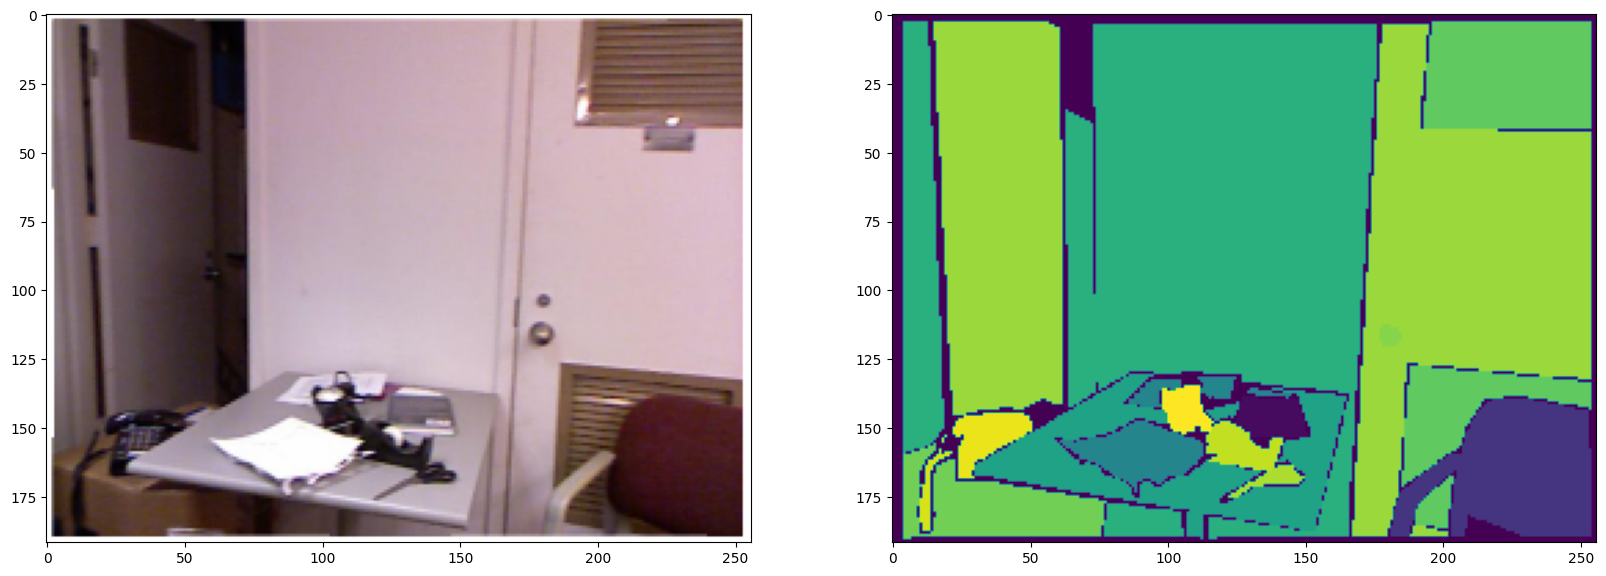

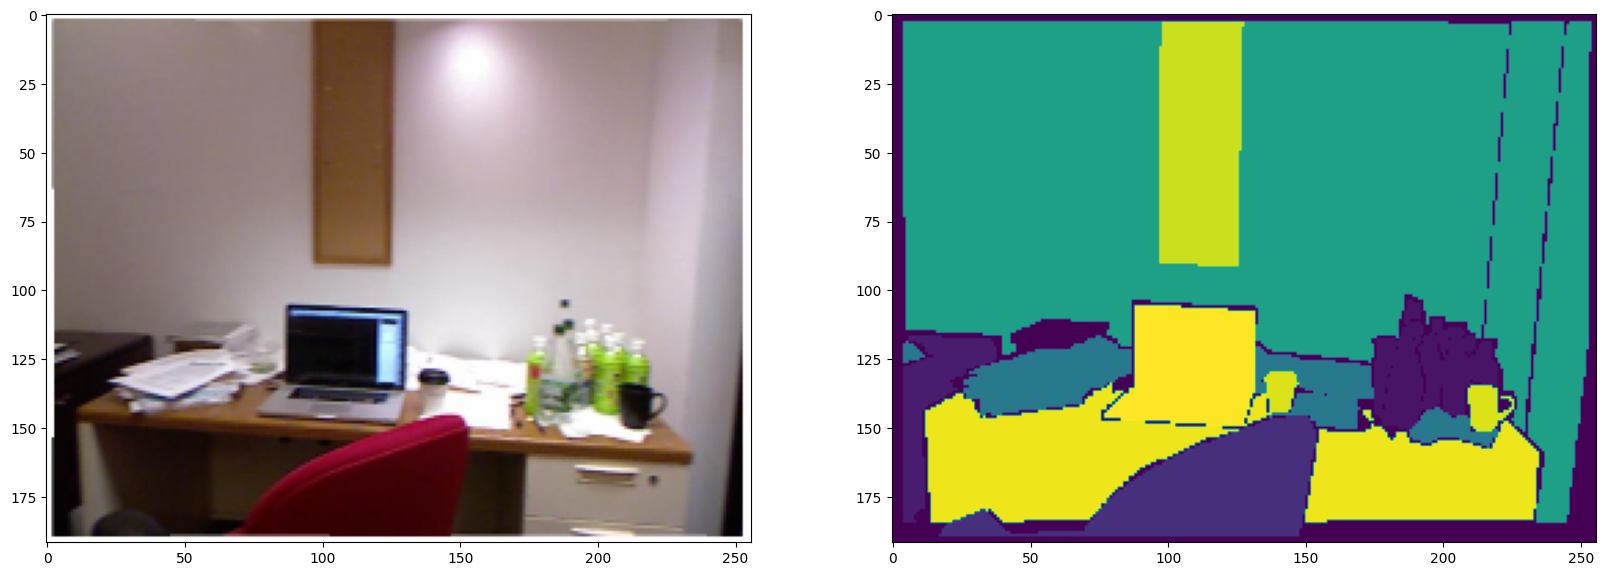

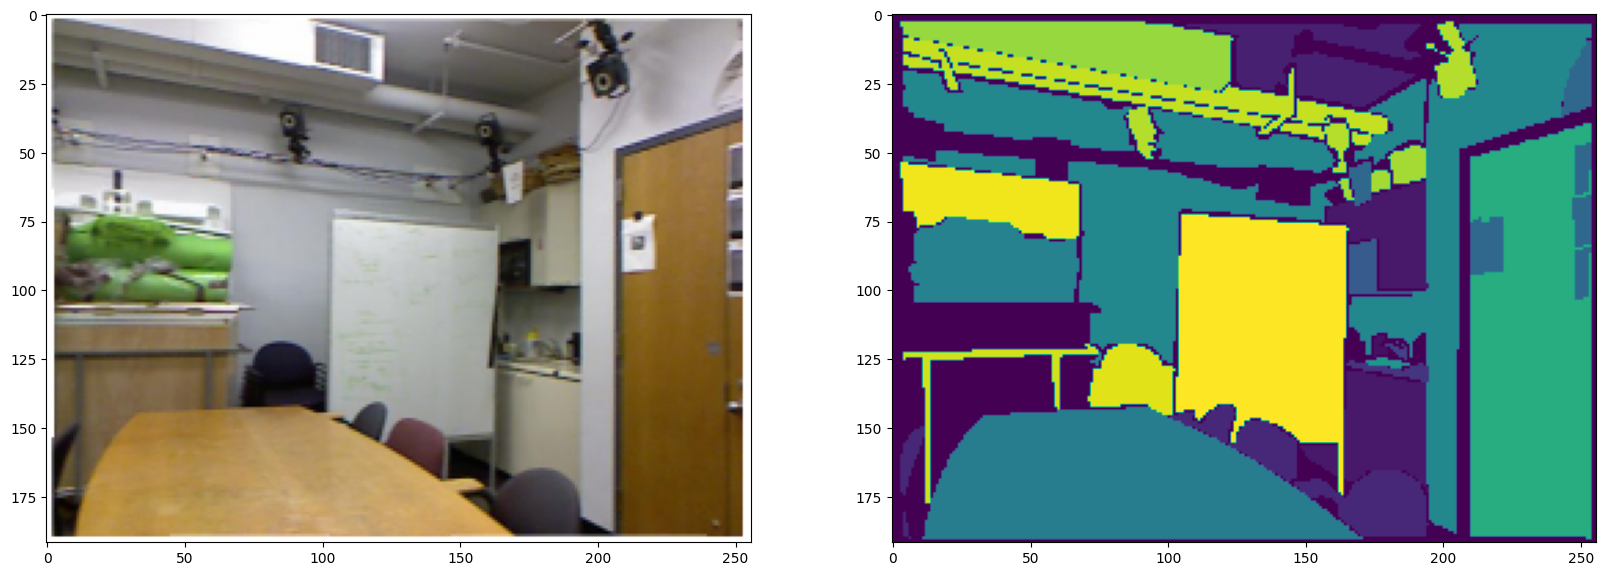

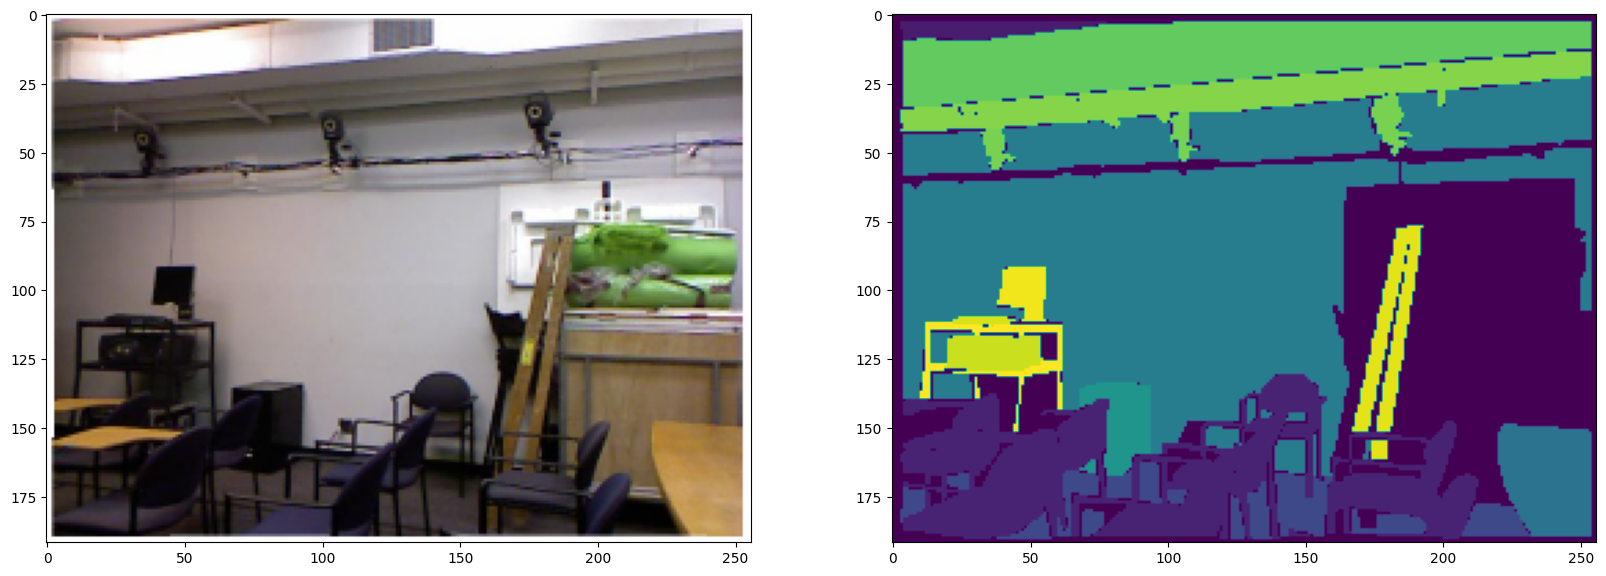

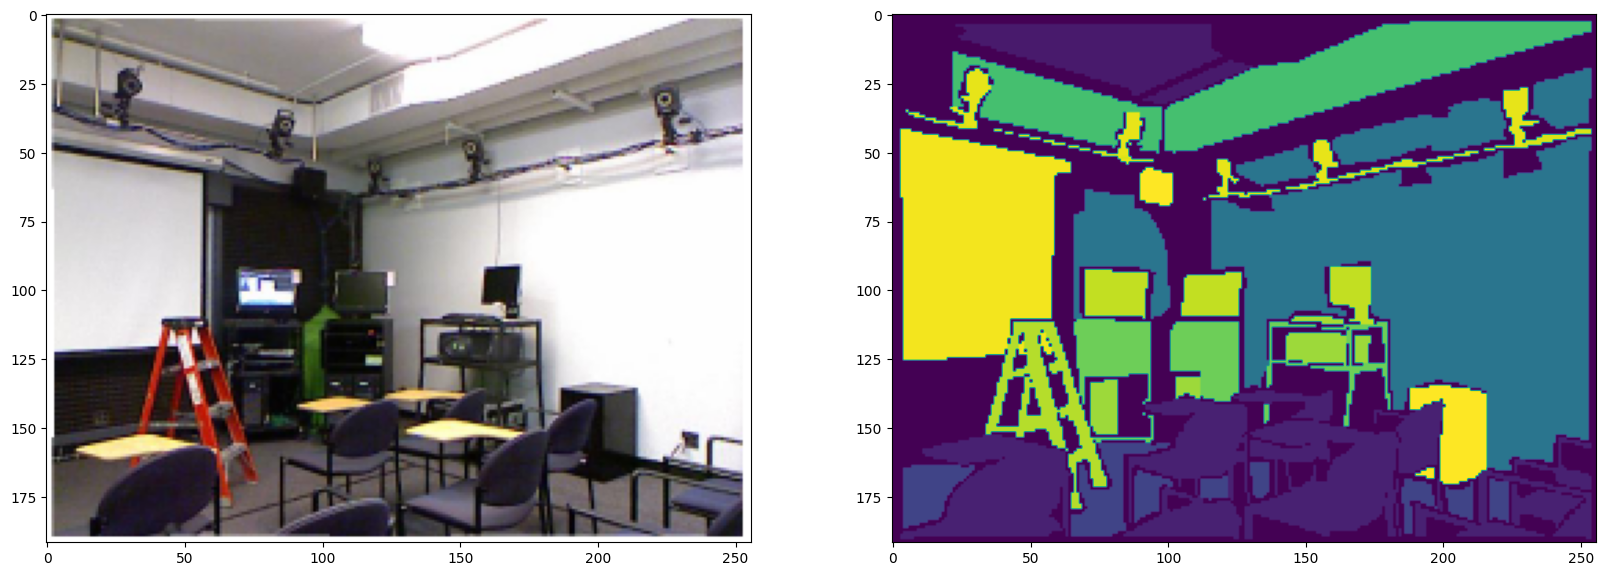

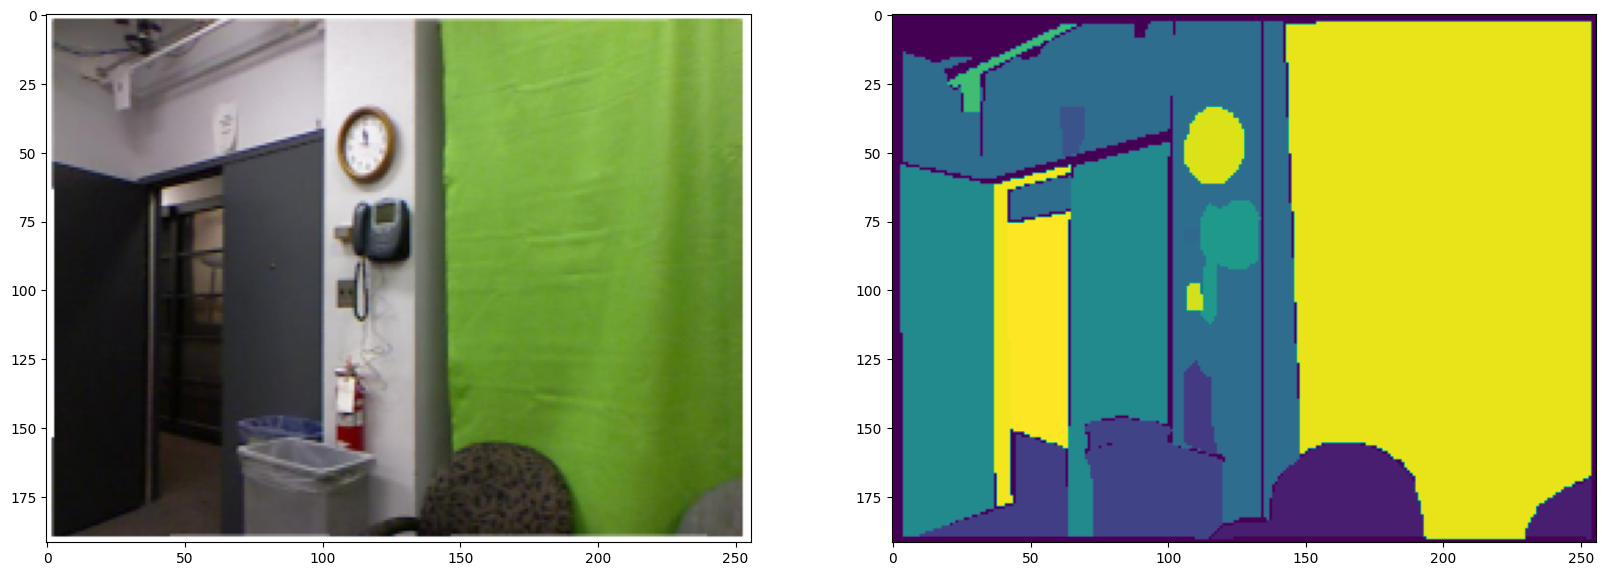

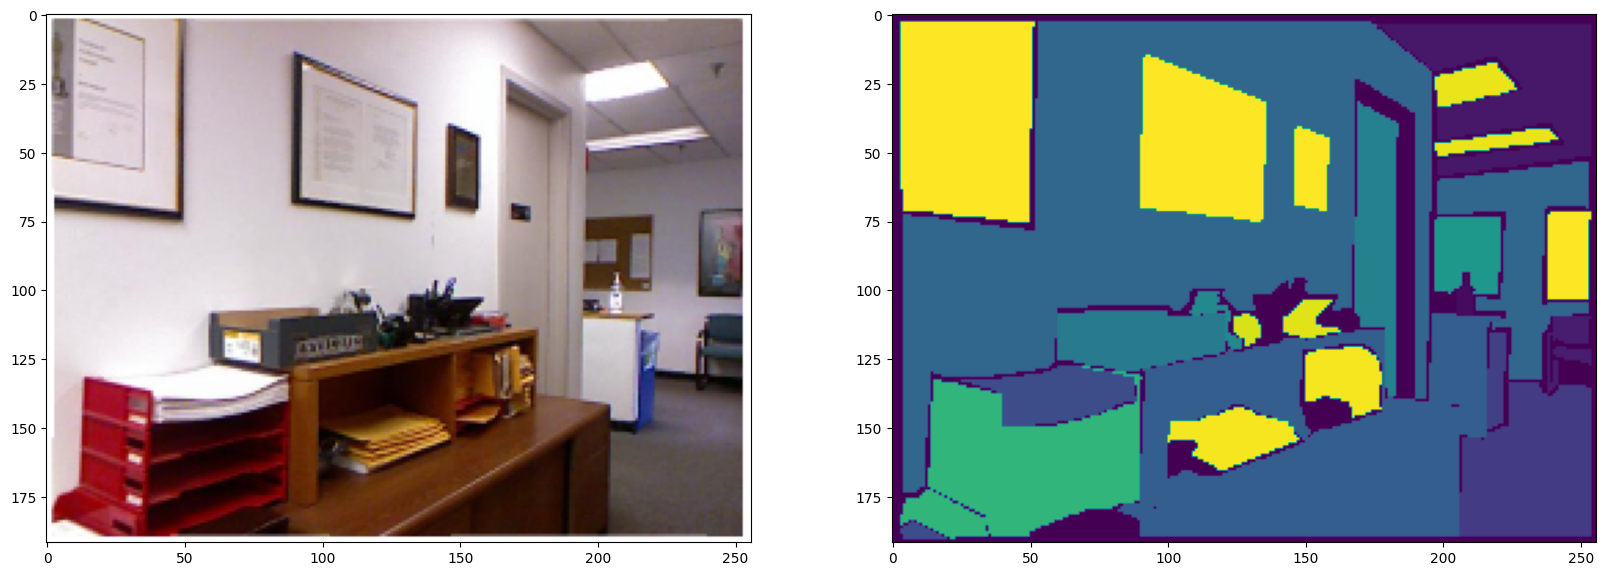

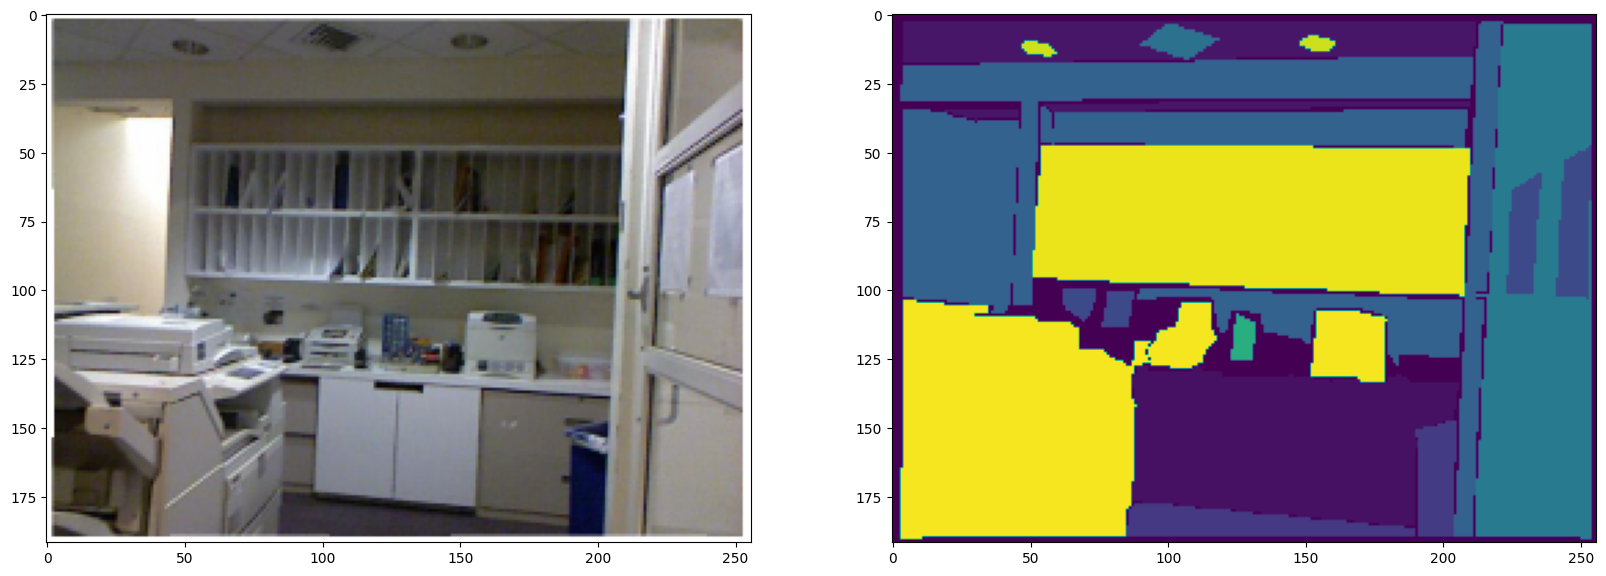

In [6]:
scale = 2.5
NYU_ds = NYU(raw_data, False, (int(480//scale), int(640//scale)))
for x in range(10):
    img, mask = NYU_ds[x]

    f, axarr = plt.subplots(1, 2, figsize=(20, 15))
    axarr[0].imshow(img.permute(1, -1, 0).numpy())
    axarr[1].imshow(mask.argmax(0).unsqueeze(0).permute(1, -1, 0).numpy())

In [7]:
train_dl = DataLoader(NYU_ds, batch_size=4, shuffle=True, pin_memory = True, num_workers=48)

print("#Training Samples: {}".format(len(NYU_ds)))
print("#Training Batch: {}".format(len(train_dl)))

#Training Samples: 1449
#Training Batch: 363


In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [9]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [10]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [11]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [12]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64)) #64, 128
        self.down2 = (Down(64, 128)) #128, 256
        self.down3 = (Down(128, 256)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(256, 512 // factor)) #512, 1024
        self.up1 = (Up(512, 256 // factor, bilinear)) #1024, 512
        self.up2 = (Up(256, 128 // factor, bilinear)) #512, 256
        self.up3 = (Up(128, 64 // factor, bilinear)) #256, 128
        self.up4 = (Up(64, 32, bilinear)) #128, 64
        self.outc = (OutConv(32, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [13]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # Average of Dice coefficient for all classes
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), reduce_batch_first, epsilon)


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, NYU_ds.cls_cnt, True).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

scheduler = CosineAnnealingLR(optimizer, epochs * len(train_dl))

loss_fn = nn.CrossEntropyLoss()

In [15]:
old_loss = 1e26
best_dct = None
last_dst = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    start_time = datetime.now()
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device, dtype=torch.float)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)
        train_rec_loss = loss_fn(train_gen_mask, train_mask)
        train_dice_loss = dice_loss(
            F.softmax(train_gen_mask, dim=1).float(),
            train_mask.float(),
            multiclass=True
        )
        train_loss = train_rec_loss + train_dice_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss += train_loss.cpu().item()
    end_time = datetime.now()
    # model.eval()
    # with torch.no_grad():
    #     va_total_loss = 0
    #     for valid_img, valid_mask in tqdm(train_dl):
    #         valid_img = valid_img.to(device)
    #         valid_mask = valid_mask.to(device)
            
    #         valid_gen_mask = model(valid_img)
    #         valid_loss = loss_fn(valid_gen_mask, valid_mask)
    #         valid_dice_loss = dice_loss(
    #             F.softmax(valid_gen_mask, dim=1).float(),
    #             valid_mask.float(),
    #             multiclass=True
    #         )
    #         valid_loss = train_rec_loss + train_dice_loss

    #         va_total_loss += valid_loss.cpu().item()
            
    mean_train_loss = tr_total_loss/len(train_dl)
    # mean_valid_loss = va_total_loss/len(test_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
    !echo "Epoch: {epoch} - TrainLoss: {mean_train_loss} - Time Consuming: {end_time - start_time}"
model.load_state_dict(best_dct)

100%|█████████████████████████████████████████████████████████████████████| 363/363 [02:34<00:00,  2.35it/s]


Epoch: 0 - TrainLoss: 4.439819141524554
Epoch: 0 - TrainLoss: 4.439819141524554 - Time Consuming: 0:02:34.472150


100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:16<00:00,  2.66it/s]


Epoch: 1 - TrainLoss: 3.386166202792123
Epoch: 1 - TrainLoss: 3.386166202792123 - Time Consuming: 0:02:16.718483


100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 2 - TrainLoss: 3.255010382859832
Epoch: 2 - TrainLoss: 3.255010382859832 - Time Consuming: 0:02:15.319758



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 3 - TrainLoss: 3.1626176190441964
Epoch: 3 - TrainLoss: 3.1626176190441964 - Time Consuming: 0:02:15.566782



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]


Epoch: 4 - TrainLoss: 3.076720748065917
Epoch: 4 - TrainLoss: 3.076720748065917 - Time Consuming: 0:02:14.443201


100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 5 - TrainLoss: 3.0039688713294415
Epoch: 5 - TrainLoss: 3.0039688713294415 - Time Consuming: 0:02:15.547291



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.71it/s]

Epoch: 6 - TrainLoss: 2.935688795137011
Epoch: 6 - TrainLoss: 2.935688795137011 - Time Consuming: 0:02:13.945626



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.69it/s]

Epoch: 7 - TrainLoss: 2.86366161170413
Epoch: 7 - TrainLoss: 2.86366161170413 - Time Consuming: 0:02:15.170158



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.73it/s]

Epoch: 8 - TrainLoss: 2.7992838309159294
Epoch: 8 - TrainLoss: 2.7992838309159294 - Time Consuming: 0:02:13.077636



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 9 - TrainLoss: 2.7411769756600877
Epoch: 9 - TrainLoss: 2.7411769756600877 - Time Consuming: 0:02:14.467180



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.71it/s]


Epoch: 10 - TrainLoss: 2.6772364075847235
Epoch: 10 - TrainLoss: 2.6772364075847235 - Time Consuming: 0:02:14.031542


100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 11 - TrainLoss: 2.630211955259654
Epoch: 11 - TrainLoss: 2.630211955259654 - Time Consuming: 0:02:15.341881



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.69it/s]

Epoch: 12 - TrainLoss: 2.5651553412771095
Epoch: 12 - TrainLoss: 2.5651553412771095 - Time Consuming: 0:02:14.783113



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:17<00:00,  2.65it/s]

Epoch: 13 - TrainLoss: 2.5011920741766938
Epoch: 13 - TrainLoss: 2.5011920741766938 - Time Consuming: 0:02:17.207353



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.69it/s]

Epoch: 14 - TrainLoss: 2.444251856528038
Epoch: 14 - TrainLoss: 2.444251856528038 - Time Consuming: 0:02:14.953103



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.71it/s]

Epoch: 15 - TrainLoss: 2.3884698714106536
Epoch: 15 - TrainLoss: 2.3884698714106536 - Time Consuming: 0:02:13.969145



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 16 - TrainLoss: 2.3522694455690623
Epoch: 16 - TrainLoss: 2.3522694455690623 - Time Consuming: 0:02:15.276071



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.69it/s]


Epoch: 17 - TrainLoss: 2.2845391248540117
Epoch: 17 - TrainLoss: 2.2845391248540117 - Time Consuming: 0:02:14.968892


100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.67it/s]

Epoch: 18 - TrainLoss: 2.2217134894089923
Epoch: 18 - TrainLoss: 2.2217134894089923 - Time Consuming: 0:02:15.958238



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.71it/s]

Epoch: 19 - TrainLoss: 2.1684906604204626
Epoch: 19 - TrainLoss: 2.1684906604204626 - Time Consuming: 0:02:13.734130



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 20 - TrainLoss: 2.101615381963325
Epoch: 20 - TrainLoss: 2.101615381963325 - Time Consuming: 0:02:14.488943



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:16<00:00,  2.66it/s]

Epoch: 21 - TrainLoss: 2.041172574045901
Epoch: 21 - TrainLoss: 2.041172574045901 - Time Consuming: 0:02:16.582561



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 22 - TrainLoss: 1.9985061673750233
Epoch: 22 - TrainLoss: 1.9985061673750233 - Time Consuming: 0:02:15.692071



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.73it/s]


Epoch: 23 - TrainLoss: 1.9250753677909367
Epoch: 23 - TrainLoss: 1.9250753677909367 - Time Consuming: 0:02:13.090469


100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 24 - TrainLoss: 1.868495508002184
Epoch: 24 - TrainLoss: 1.868495508002184 - Time Consuming: 0:02:14.213123



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 25 - TrainLoss: 1.832501899440755
Epoch: 25 - TrainLoss: 1.832501899440755 - Time Consuming: 0:02:15.643109



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.73it/s]

Epoch: 26 - TrainLoss: 1.7577061367428992
Epoch: 26 - TrainLoss: 1.7577061367428992 - Time Consuming: 0:02:13.050241



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.69it/s]

Epoch: 27 - TrainLoss: 1.716427558381367
Epoch: 27 - TrainLoss: 1.716427558381367 - Time Consuming: 0:02:14.996173



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:16<00:00,  2.67it/s]

Epoch: 28 - TrainLoss: 1.6524687258336825
Epoch: 28 - TrainLoss: 1.6524687258336825 - Time Consuming: 0:02:16.156601



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:11<00:00,  2.76it/s]

Epoch: 29 - TrainLoss: 1.5967219294595325
Epoch: 29 - TrainLoss: 1.5967219294595325 - Time Consuming: 0:02:11.743226



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:17<00:00,  2.64it/s]

Epoch: 30 - TrainLoss: 1.550158600833462
Epoch: 30 - TrainLoss: 1.550158600833462 - Time Consuming: 0:02:17.269335



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.71it/s]

Epoch: 31 - TrainLoss: 1.4929734987332473
Epoch: 31 - TrainLoss: 1.4929734987332473 - Time Consuming: 0:02:14.091085



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.71it/s]

Epoch: 32 - TrainLoss: 1.4546314760344745
Epoch: 32 - TrainLoss: 1.4546314760344745 - Time Consuming: 0:02:14.165159



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.67it/s]

Epoch: 33 - TrainLoss: 1.4179327455105533
Epoch: 33 - TrainLoss: 1.4179327455105533 - Time Consuming: 0:02:15.997484



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.72it/s]

Epoch: 34 - TrainLoss: 1.366306990959756
Epoch: 34 - TrainLoss: 1.366306990959756 - Time Consuming: 0:02:13.278264



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 35 - TrainLoss: 1.3172137926104313
Epoch: 35 - TrainLoss: 1.3172137926104313 - Time Consuming: 0:02:15.646784



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.71it/s]

Epoch: 36 - TrainLoss: 1.2819421102521176
Epoch: 36 - TrainLoss: 1.2819421102521176 - Time Consuming: 0:02:14.056897



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:11<00:00,  2.76it/s]

Epoch: 37 - TrainLoss: 1.248867347384944
Epoch: 37 - TrainLoss: 1.248867347384944 - Time Consuming: 0:02:11.714061



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.72it/s]

Epoch: 38 - TrainLoss: 1.2062737036999265
Epoch: 38 - TrainLoss: 1.2062737036999265 - Time Consuming: 0:02:13.625509



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 39 - TrainLoss: 1.1548241807081154
Epoch: 39 - TrainLoss: 1.1548241807081154 - Time Consuming: 0:02:14.376514



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.67it/s]

Epoch: 40 - TrainLoss: 1.1308185321897186
Epoch: 40 - TrainLoss: 1.1308185321897186 - Time Consuming: 0:02:15.750215



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.72it/s]


Epoch: 41 - TrainLoss: 1.1236012050928164
Epoch: 41 - TrainLoss: 1.1236012050928164 - Time Consuming: 0:02:13.619179


100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:12<00:00,  2.74it/s]

Epoch: 42 - TrainLoss: 1.058039514814855
Epoch: 42 - TrainLoss: 1.058039514814855 - Time Consuming: 0:02:12.370773



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.71it/s]

Epoch: 43 - TrainLoss: 1.0287301023144366
Epoch: 43 - TrainLoss: 1.0287301023144366 - Time Consuming: 0:02:13.891876



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 44 - TrainLoss: 1.0110035139667102
Epoch: 44 - TrainLoss: 1.0110035139667102 - Time Consuming: 0:02:14.280934



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.72it/s]


Epoch: 45 - TrainLoss: 0.9845234127740886
Epoch: 45 - TrainLoss: 0.9845234127740886 - Time Consuming: 0:02:13.622143


100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 46 - TrainLoss: 0.962237720482934
Epoch: 46 - TrainLoss: 0.962237720482934 - Time Consuming: 0:02:14.402336



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 47 - TrainLoss: 0.9378723759953312
Epoch: 47 - TrainLoss: 0.9378723759953312 - Time Consuming: 0:02:15.387102



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 48 - TrainLoss: 0.9000922883180876
Epoch: 48 - TrainLoss: 0.9000922883180876 - Time Consuming: 0:02:15.565616



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:16<00:00,  2.66it/s]

Epoch: 49 - TrainLoss: 0.8798137018995836
Epoch: 49 - TrainLoss: 0.8798137018995836 - Time Consuming: 0:02:16.723481



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.69it/s]

Epoch: 50 - TrainLoss: 0.8652979900685881
Epoch: 50 - TrainLoss: 0.8652979900685881 - Time Consuming: 0:02:14.882353



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 51 - TrainLoss: 0.8459349675283616
Epoch: 51 - TrainLoss: 0.8459349675283616 - Time Consuming: 0:02:14.241723



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.69it/s]

Epoch: 52 - TrainLoss: 0.8219349593663019
Epoch: 52 - TrainLoss: 0.8219349593663019 - Time Consuming: 0:02:14.755799



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:16<00:00,  2.66it/s]

Epoch: 53 - TrainLoss: 0.80341756926752
Epoch: 53 - TrainLoss: 0.80341756926752 - Time Consuming: 0:02:16.251409



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.67it/s]

Epoch: 54 - TrainLoss: 0.7834471868910409
Epoch: 54 - TrainLoss: 0.7834471868910409 - Time Consuming: 0:02:15.831342



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.72it/s]

Epoch: 55 - TrainLoss: 0.768780669233359
Epoch: 55 - TrainLoss: 0.768780669233359 - Time Consuming: 0:02:13.303665



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 56 - TrainLoss: 0.751844290613143
Epoch: 56 - TrainLoss: 0.751844290613143 - Time Consuming: 0:02:15.433250



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:12<00:00,  2.75it/s]

Epoch: 57 - TrainLoss: 0.7359355588754019
Epoch: 57 - TrainLoss: 0.7359355588754019 - Time Consuming: 0:02:12.012656



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 58 - TrainLoss: 0.7166299916003361
Epoch: 58 - TrainLoss: 0.7166299916003361 - Time Consuming: 0:02:15.515895



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.71it/s]

Epoch: 59 - TrainLoss: 0.7044304224249417
Epoch: 59 - TrainLoss: 0.7044304224249417 - Time Consuming: 0:02:14.066915



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.69it/s]

Epoch: 60 - TrainLoss: 0.6946562280668043
Epoch: 60 - TrainLoss: 0.6946562280668043 - Time Consuming: 0:02:15.079343



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:16<00:00,  2.66it/s]

Epoch: 61 - TrainLoss: 0.689558832359708
Epoch: 61 - TrainLoss: 0.689558832359708 - Time Consuming: 0:02:16.480757



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 62 - TrainLoss: 0.6633564135259833
Epoch: 62 - TrainLoss: 0.6633564135259833 - Time Consuming: 0:02:14.302332



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 63 - TrainLoss: 0.6529745385666524
Epoch: 63 - TrainLoss: 0.6529745385666524 - Time Consuming: 0:02:14.572938



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 64 - TrainLoss: 0.6426551577637675
Epoch: 64 - TrainLoss: 0.6426551577637675 - Time Consuming: 0:02:14.254898



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:16<00:00,  2.66it/s]

Epoch: 65 - TrainLoss: 0.6285169117214265
Epoch: 65 - TrainLoss: 0.6285169117214265 - Time Consuming: 0:02:16.234312



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]


Epoch: 66 - TrainLoss: 0.626650140469396
Epoch: 66 - TrainLoss: 0.626650140469396 - Time Consuming: 0:02:14.235322


100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.72it/s]

Epoch: 67 - TrainLoss: 0.6249488152091497
Epoch: 67 - TrainLoss: 0.6249488152091497 - Time Consuming: 0:02:13.484655



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:12<00:00,  2.74it/s]

Epoch: 68 - TrainLoss: 0.6103742121829145
Epoch: 68 - TrainLoss: 0.6103742121829145 - Time Consuming: 0:02:12.421273



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 69 - TrainLoss: 0.6031638782050656
Epoch: 69 - TrainLoss: 0.6031638782050656 - Time Consuming: 0:02:15.534688



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.69it/s]

Epoch: 70 - TrainLoss: 0.586341699128637
Epoch: 70 - TrainLoss: 0.586341699128637 - Time Consuming: 0:02:14.710952



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 71 - TrainLoss: 0.574579958334442
Epoch: 71 - TrainLoss: 0.574579958334442 - Time Consuming: 0:02:14.660530



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.72it/s]

Epoch: 72 - TrainLoss: 0.5669033711278406
Epoch: 72 - TrainLoss: 0.5669033711278406 - Time Consuming: 0:02:13.648656



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.71it/s]

Epoch: 73 - TrainLoss: 0.5636363710089491
Epoch: 73 - TrainLoss: 0.5636363710089491 - Time Consuming: 0:02:13.880202



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.72it/s]

Epoch: 74 - TrainLoss: 0.5574708880635989
Epoch: 74 - TrainLoss: 0.5574708880635989 - Time Consuming: 0:02:13.542685



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:12<00:00,  2.73it/s]

Epoch: 75 - TrainLoss: 0.5510218667261528
Epoch: 75 - TrainLoss: 0.5510218667261528 - Time Consuming: 0:02:12.831961



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.67it/s]

Epoch: 76 - TrainLoss: 0.5503535864274364
Epoch: 76 - TrainLoss: 0.5503535864274364 - Time Consuming: 0:02:15.740957



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 77 - TrainLoss: 0.5362928521206228
Epoch: 77 - TrainLoss: 0.5362928521206228 - Time Consuming: 0:02:15.387797



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.69it/s]

Epoch: 78 - TrainLoss: 0.5343065958049343
Epoch: 78 - TrainLoss: 0.5343065958049343 - Time Consuming: 0:02:14.873299



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.67it/s]

Epoch: 79 - TrainLoss: 0.5340251324918973
Epoch: 79 - TrainLoss: 0.5340251324918973 - Time Consuming: 0:02:15.799017



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 80 - TrainLoss: 0.5268020510837723
Epoch: 80 - TrainLoss: 0.5268020510837723 - Time Consuming: 0:02:15.408620



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.68it/s]

Epoch: 81 - TrainLoss: 0.5236910584051747
Epoch: 81 - TrainLoss: 0.5236910584051747 - Time Consuming: 0:02:15.527060



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.72it/s]

Epoch: 82 - TrainLoss: 0.5150566826838764
Epoch: 82 - TrainLoss: 0.5150566826838764 - Time Consuming: 0:02:13.256718



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.69it/s]

Epoch: 83 - TrainLoss: 0.5122247526304124
Epoch: 83 - TrainLoss: 0.5122247526304124 - Time Consuming: 0:02:14.840244



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:13<00:00,  2.71it/s]

Epoch: 84 - TrainLoss: 0.5099684517245647
Epoch: 84 - TrainLoss: 0.5099684517245647 - Time Consuming: 0:02:13.905078



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 85 - TrainLoss: 0.5055260376660948
Epoch: 85 - TrainLoss: 0.5055260376660948 - Time Consuming: 0:02:14.406249



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:16<00:00,  2.66it/s]

Epoch: 86 - TrainLoss: 0.5070920237660737
Epoch: 86 - TrainLoss: 0.5070920237660737 - Time Consuming: 0:02:16.319060



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.70it/s]

Epoch: 87 - TrainLoss: 0.5041874724314561
Epoch: 87 - TrainLoss: 0.5041874724314561 - Time Consuming: 0:02:14.598268



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.67it/s]

Epoch: 88 - TrainLoss: 0.4993072669368145
Epoch: 88 - TrainLoss: 0.4993072669368145 - Time Consuming: 0:02:15.751929



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.69it/s]

Epoch: 89 - TrainLoss: 0.49900002789891457
Epoch: 89 - TrainLoss: 0.49900002789891457 - Time Consuming: 0:02:15.093964



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:16<00:00,  2.67it/s]

Epoch: 90 - TrainLoss: 0.49631369975972767
Epoch: 90 - TrainLoss: 0.49631369975972767 - Time Consuming: 0:02:16.160379



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:16<00:00,  2.67it/s]

Epoch: 91 - TrainLoss: 0.4968424192309051
Epoch: 91 - TrainLoss: 0.4968424192309051 - Time Consuming: 0:02:16.071722



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:18<00:00,  2.62it/s]

Epoch: 92 - TrainLoss: 0.4926391374473729
Epoch: 92 - TrainLoss: 0.4926391374473729 - Time Consuming: 0:02:18.771986



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.67it/s]

Epoch: 93 - TrainLoss: 0.4927423027428714
Epoch: 93 - TrainLoss: 0.4927423027428714 - Time Consuming: 0:02:15.954650



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:17<00:00,  2.65it/s]

Epoch: 94 - TrainLoss: 0.4925772193049596
Epoch: 94 - TrainLoss: 0.4925772193049596 - Time Consuming: 0:02:17.007465



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:17<00:00,  2.64it/s]

Epoch: 95 - TrainLoss: 0.49334913270532593
Epoch: 95 - TrainLoss: 0.49334913270532593 - Time Consuming: 0:02:17.362965



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:15<00:00,  2.67it/s]

Epoch: 96 - TrainLoss: 0.4929074375754217
Epoch: 96 - TrainLoss: 0.4929074375754217 - Time Consuming: 0:02:15.747790



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:17<00:00,  2.64it/s]

Epoch: 97 - TrainLoss: 0.4959584921187934
Epoch: 97 - TrainLoss: 0.4959584921187934 - Time Consuming: 0:02:17.356325



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:14<00:00,  2.69it/s]

Epoch: 98 - TrainLoss: 0.49485446377234027
Epoch: 98 - TrainLoss: 0.49485446377234027 - Time Consuming: 0:02:14.929441



100%|███████████████████████████████████████████████████████████████████████████████████████████| 363/363 [02:18<00:00,  2.63it/s]

Epoch: 99 - TrainLoss: 0.49372612116422204
Epoch: 99 - TrainLoss: 0.49372612116422204 - Time Consuming: 0:02:18.179216


<All keys matched successfully>

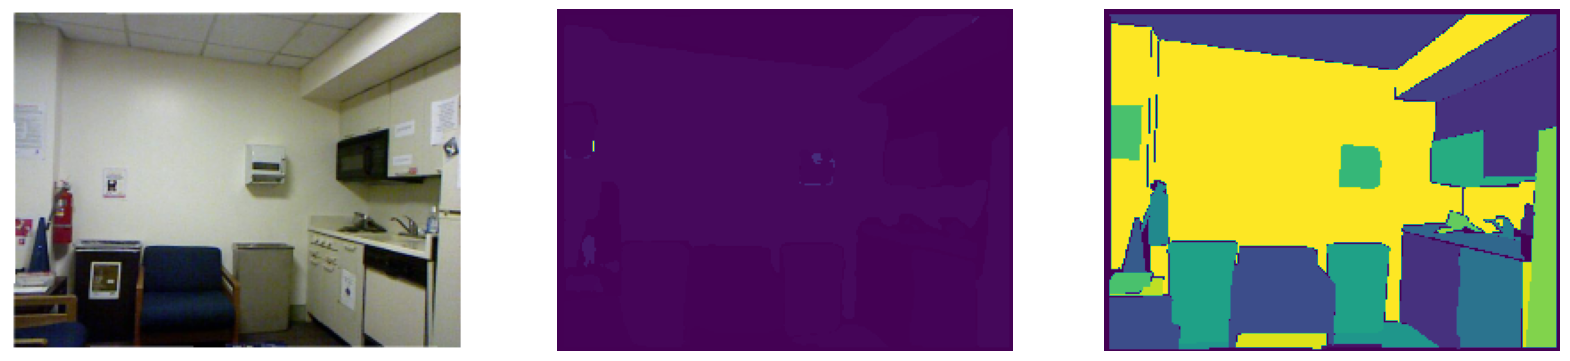

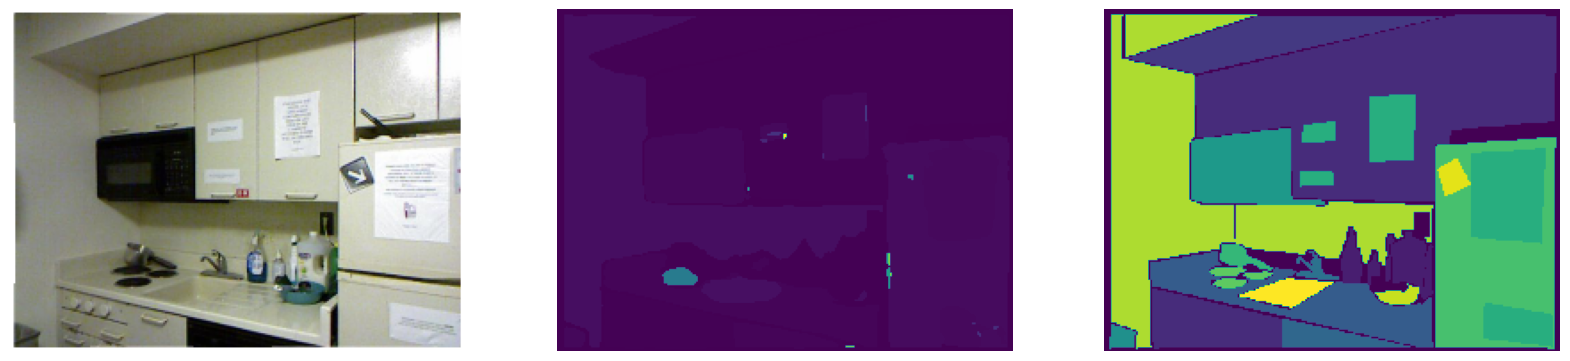

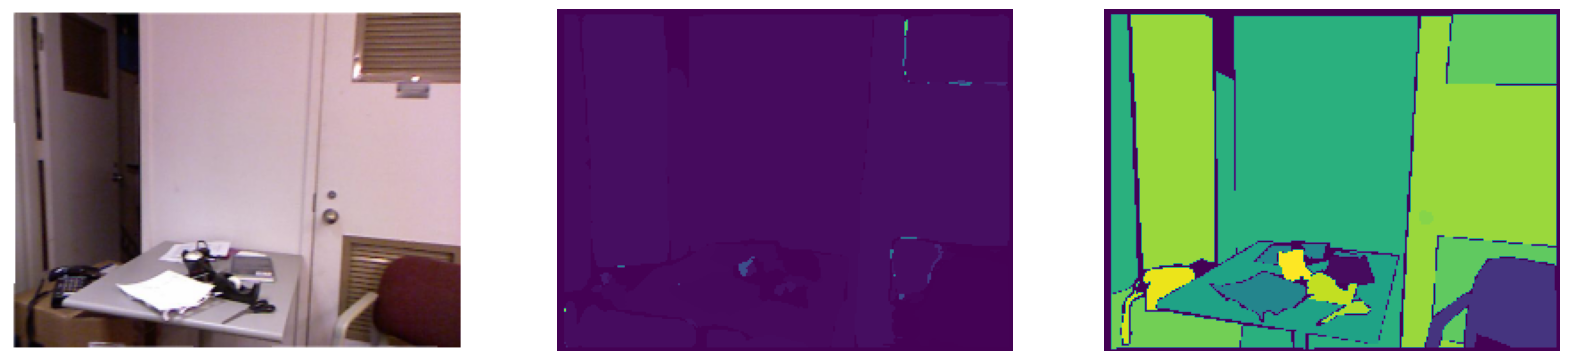

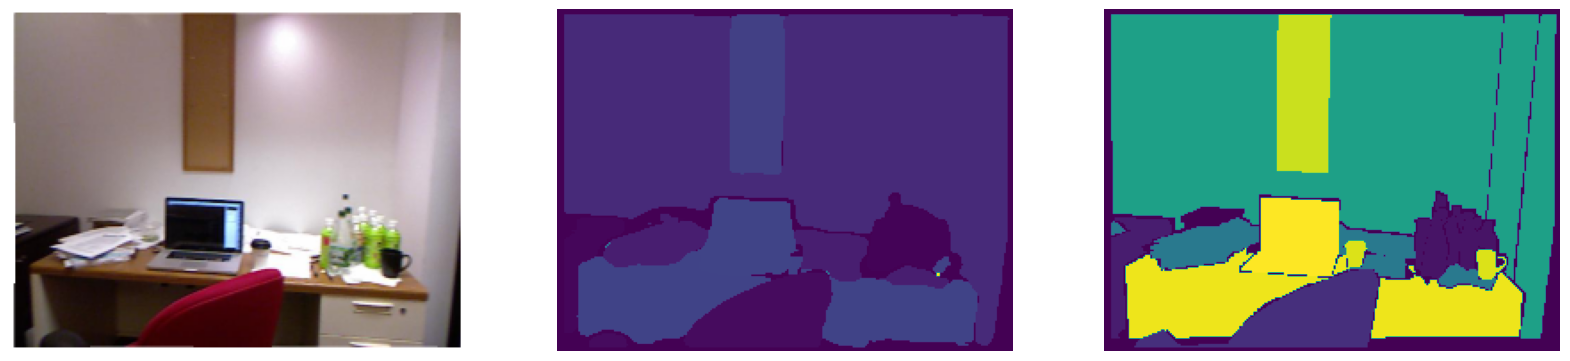

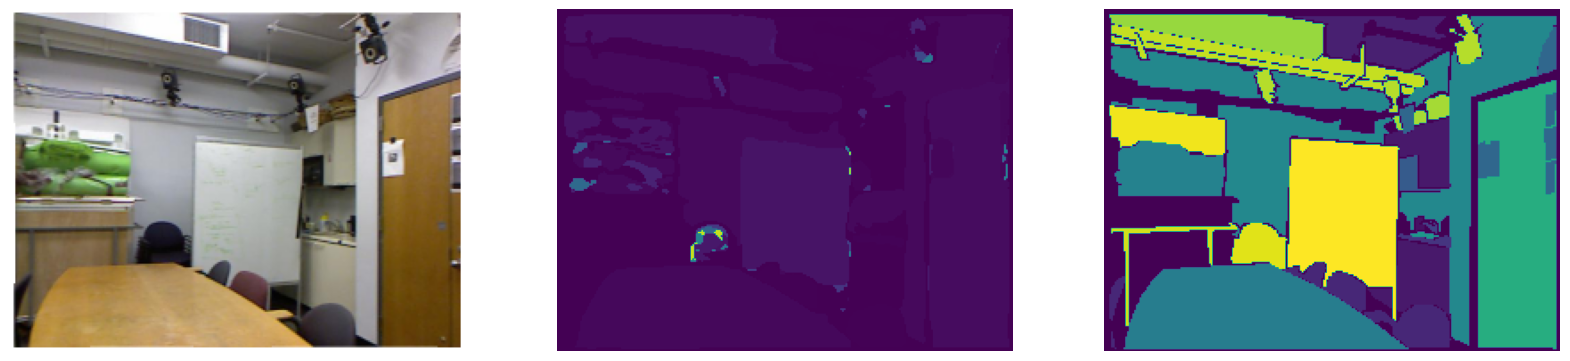

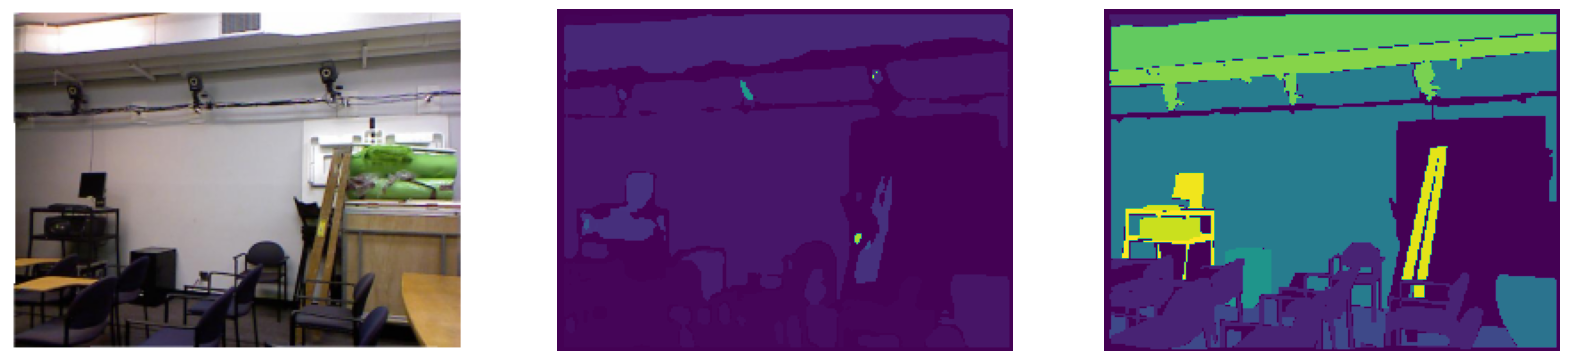

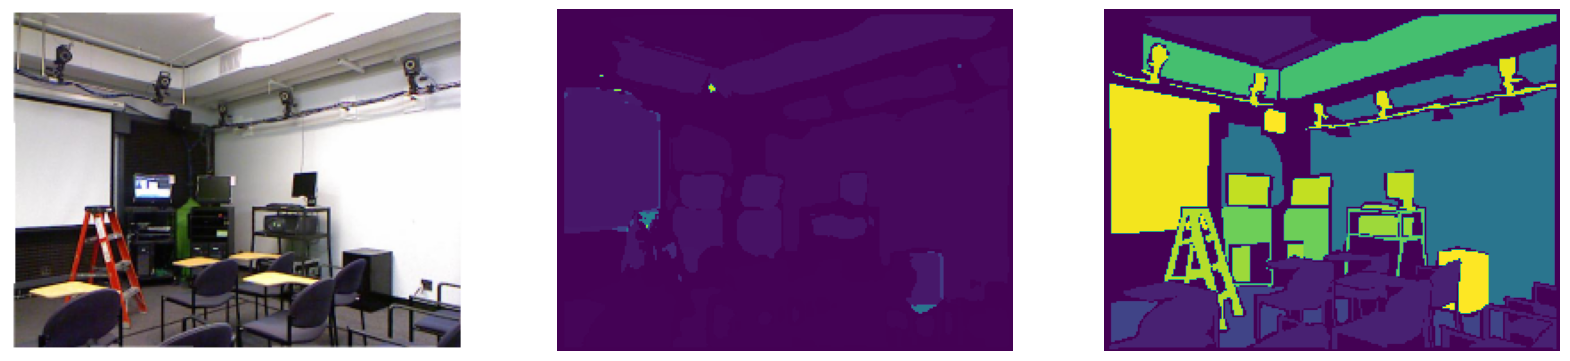

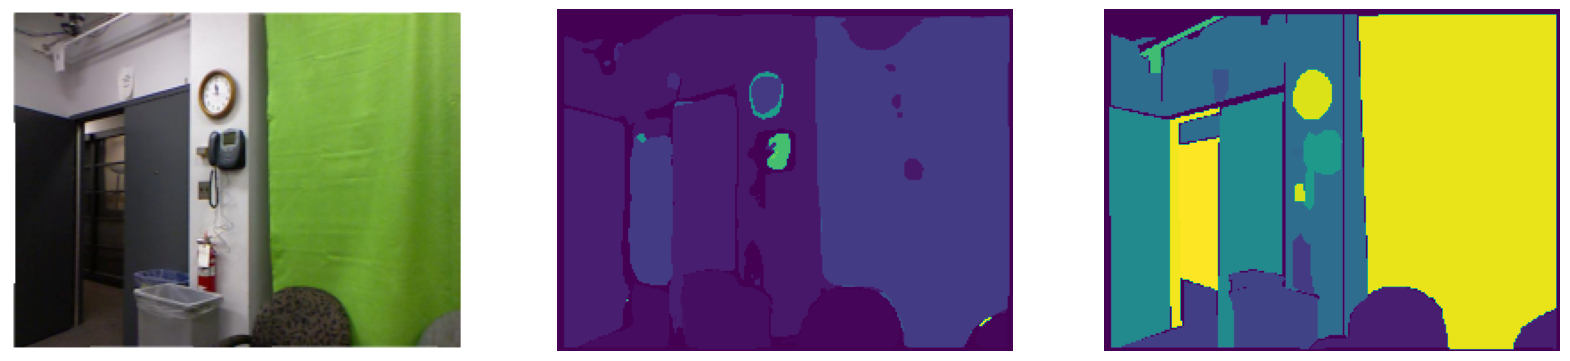

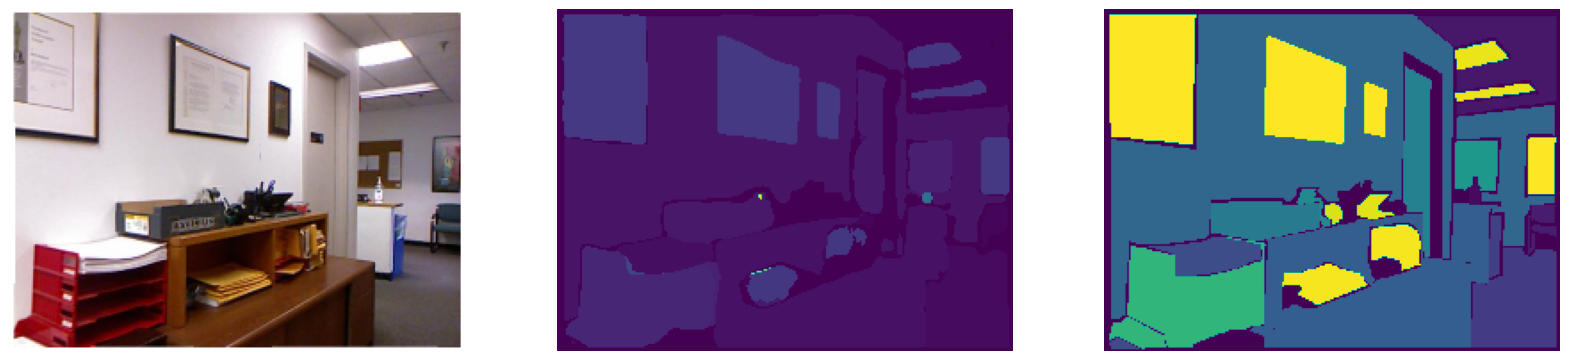

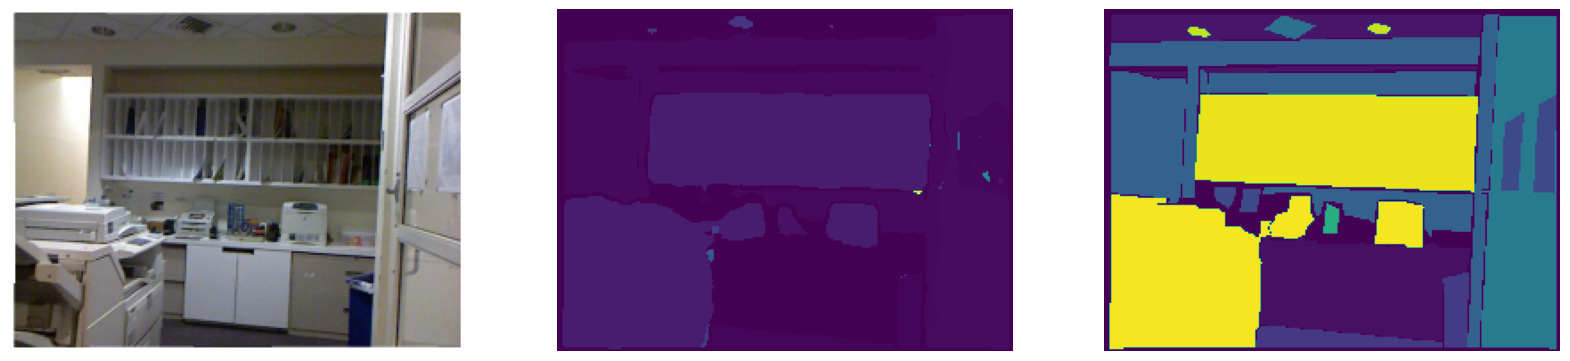

In [21]:
model.eval()

with torch.no_grad():
    for test_case_idx in range(10):
        valid_img, valid_mask = NYU_ds[test_case_idx]
        cuda_valid_img = valid_img.unsqueeze(dim=0).to(device, dtype = torch.float)

        gen_mask = model(cuda_valid_img)     
        # f, axarr = plt.subplots(1, total_num_class + 3, figsize = (20,15))
        f, axarr = plt.subplots(1, 3, figsize = (20,15))
        axarr[0].imshow(valid_img.cpu().permute(1, -1, 0).numpy())
        axarr[0].axis('off')
        axarr[1].imshow(torch.argmax(gen_mask[0], dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[1].axis('off')
        axarr[2].imshow(torch.argmax(valid_mask, dim=0).cpu().unsqueeze(0).permute(1, -1, 0).numpy())
        axarr[2].axis('off')
        # for idx in range(total_num_class):
        #     axarr[idx + 2].imshow(gen_mask[0][idx].unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        #     axarr[idx + 2].axis('off')
        # axarr[total_num_class+2].imshow(torch.argmax(valid_mask, dim=0).unsqueeze(0).cpu().permute(1, -1, 0).numpy())
        # axarr[total_num_class+2].axis('off')